<a href="https://colab.research.google.com/github/lntelliMed/chest-xray-pneumonia-detection/blob/master/chest_xray_pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
for dirname in os.walk('/content/drive/My Drive/kaggle/chest_xray'):
    print(dirname)

('/content/drive/My Drive/kaggle/chest_xray', ['val', 'test', 'train'], [])
('/content/drive/My Drive/kaggle/chest_xray/val', ['NORMAL', 'PNEUMONIA'], [])
('/content/drive/My Drive/kaggle/chest_xray/val/NORMAL', [], ['NORMAL2-IM-1440-0001.jpeg', 'NORMAL2-IM-1437-0001.jpeg', '.DS_Store', 'NORMAL2-IM-1431-0001.jpeg', 'NORMAL2-IM-1438-0001.jpeg', 'NORMAL2-IM-1427-0001.jpeg', 'NORMAL2-IM-1442-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg', 'NORMAL2-IM-1436-0001.jpeg'])
('/content/drive/My Drive/kaggle/chest_xray/val/PNEUMONIA', [], ['.DS_Store', 'person1952_bacteria_4883.jpeg', 'person1951_bacteria_4882.jpeg', 'person1949_bacteria_4880.jpeg', 'person1946_bacteria_4874.jpeg', 'person1946_bacteria_4875.jpeg', 'person1954_bacteria_4886.jpeg', 'person1950_bacteria_4881.jpeg', 'person1947_bacteria_4876.jpeg'])
('/content/drive/My Drive/kaggle/chest_xray/test', ['PNEUMONIA', 'NORMAL'], [])
('/content/drive/My Drive/kaggle/chest_xray/test/PNEUMONIA', [], ['person147_bacteria_706.jpeg', 'person119_bacter

In [0]:
training_dir = '/content/drive/My Drive/kaggle/chest_xray/train'
validation_dir = '/content/drive/My Drive/kaggle/chest_xray/test'
test_dir = '/content/drive/My Drive/kaggle/chest_xray/val'

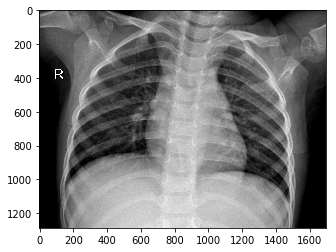

In [0]:
img = mpimg.imread(training_dir + '/NORMAL/NORMAL2-IM-1180-0001.jpeg')
imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)

      amount += 1

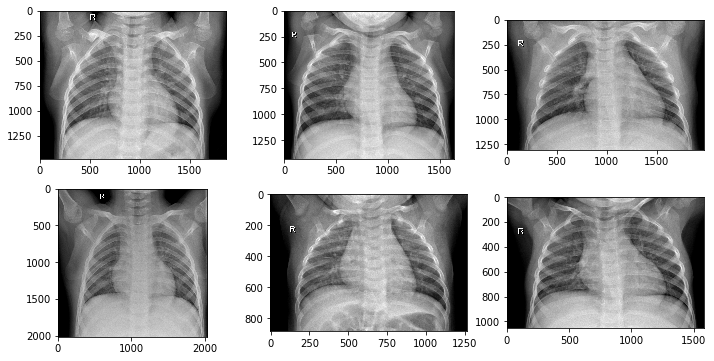

In [0]:
plot_images(training_dir + '/NORMAL')

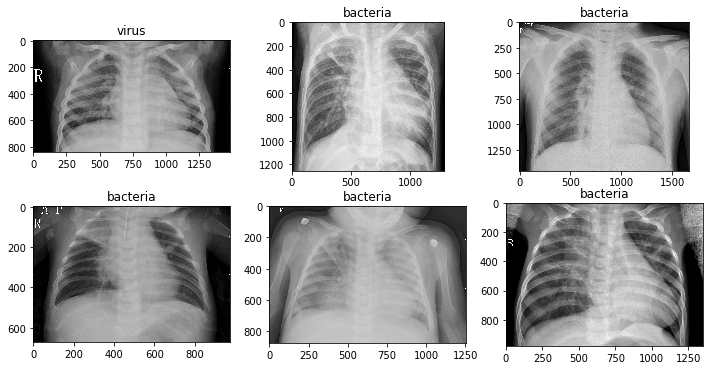

In [0]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

In [0]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [0]:
model = get_model()









87916544/87910968 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
___________________

In [0]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 1328s 8s/step - loss: 0.3885 - acc: 0.8637 - val_loss: 1.5554 - val_acc: 0.6699
Epoch 2/5
163/163 [==============================] - 381s 2s/step - loss: 0.2722 - acc: 0.8934 - val_loss: 1.0092 - val_acc: 0.7067
Epoch 3/5
163/163 [==============================] - 381s 2s/step - loss: 0.2577 - acc: 0.8959 - val_loss: 2.1848 - val_acc: 0.6891
Epoch 4/5
163/163 [==============================] - 382s 2s/step - loss: 0.2487 - acc: 0.8976 - val_loss: 3.1341 - val_acc: 0.6378
Epoch 5/5
163/163 [==============================] - 382s 2s/step - loss: 0.2382 - acc: 0.9030 - val_loss: 3.0284 - val_acc: 0.6490


In [0]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 2s 114ms/step
Loss: 3.6173917216025053
Accuracy: 0.5


In [0]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]

In [0]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 9:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)

      amount += 1

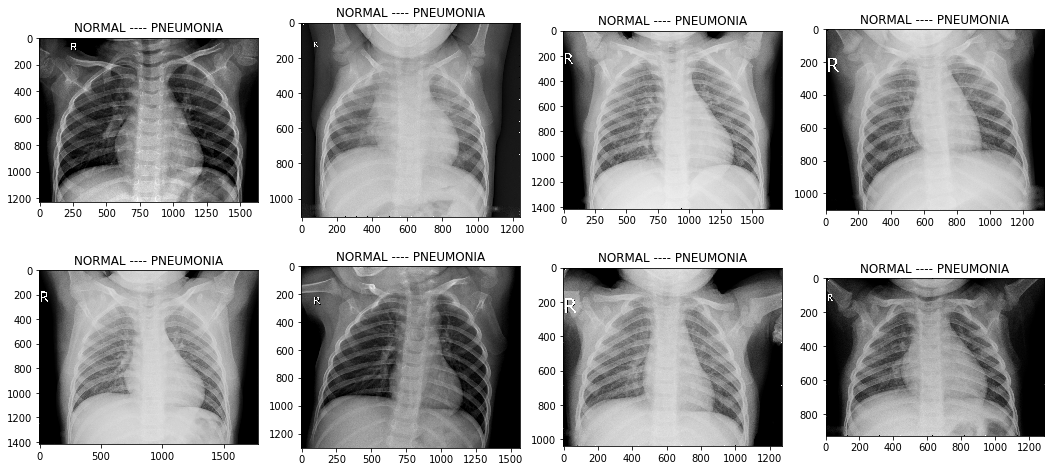

In [0]:
predict_images('/content/drive/My Drive/kaggle/chest_xray/val/NORMAL', 'NORMAL')

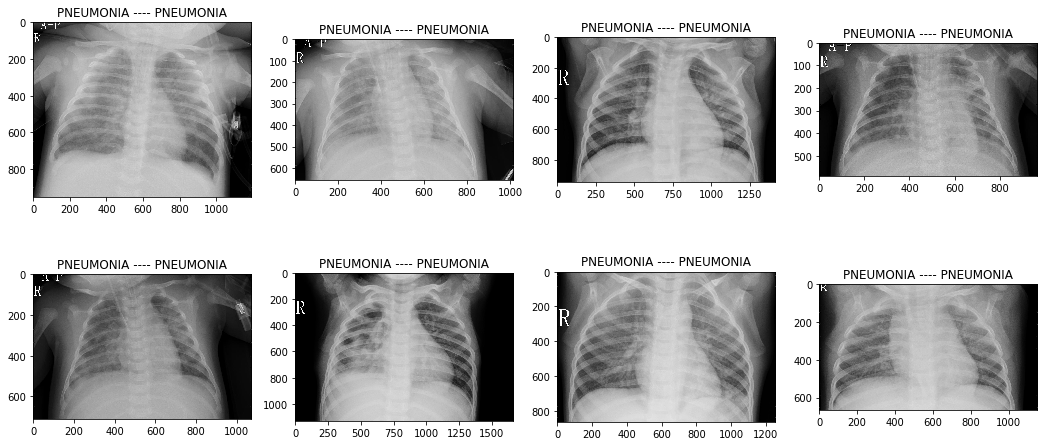

In [0]:
predict_images('/content/drive/My Drive/kaggle/chest_xray/val/PNEUMONIA', 'PNEUMONIA')

In [0]:
# model.save('awesome_model.h5')
# new_model = keras.models.load_model('awesome_model.h5')

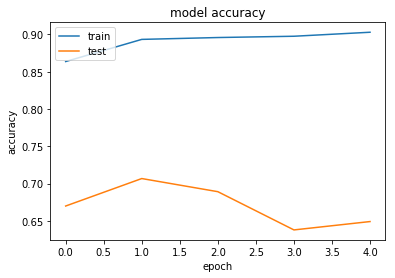

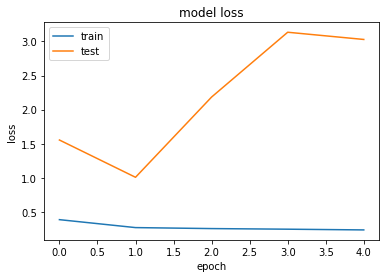

In [60]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()